In [1]:
import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
import sklearn.cluster
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)

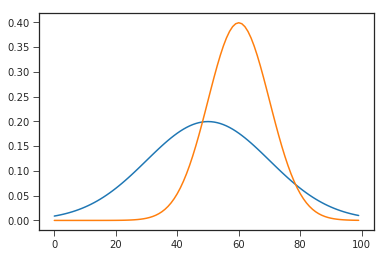

In [2]:
plt.plot([scipy.stats.norm(0, 2).pdf(x) for x in np.arange(-5, 5, 0.1)])
plt.plot([scipy.stats.norm(1, 1).pdf(x) for x in np.arange(-5, 5, 0.1)])

In [3]:
X_tr = scipy.stats.norm(0, 2).rvs(300)
X_te = scipy.stats.norm(1, 1).rvs(1000)

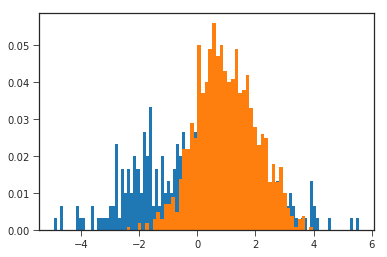

In [4]:
weights_tr = np.ones_like(X_tr)/len(X_tr)
weights_te = np.ones_like(X_te)/len(X_te)
plt.hist(X_tr, bins=100, weights=weights_tr)
plt.hist(X_te, bins=50, weights=weights_te)
plt.show()

In [5]:
def norm(X, mean, sigma):
    cov = np.eye(len(mean)) * sigma
    return scipy.stats.multivariate_normal.pdf(X, mean=mean, cov=cov)


class ULsifLooCV(object):
    def __init__(self, sigmas, lambdas):
        self._sigmas = sigmas
        self._lambdas = lambdas
    
    def fit(self, X_tr, X_te):
        n_tr = len(X_tr)
        n_te = len(X_te)
        b = min(100, n_te)
        n = min(n_tr, n_te)
        means = sklearn.cluster.KMeans(b).fit(X_tr).cluster_centers_
        
        score = np.inf
        for sigma in self._sigmas:
            phi_tr = np.array([norm(X_tr, mean, sigma) for mean in means])
            phi_te = np.array([norm(X_te, mean, sigma) for mean in means])
            H = phi_tr.dot(phi_tr.transpose()) / n_tr
            h = np.mean(phi_te, axis=1)
            
            for lamb in self._lambdas:
                B = H + lamb * (n_tr - 1) / n_tr * np.eye(b)
                B_inv_phi_tr = np.linalg.solve(B, phi_tr[:, :n])
                denom = n_tr - np.sum(phi_tr[:, :n] * B_inv_phi_tr, axis=0)
                B0 = np.repeat(np.linalg.solve(B, h), n).reshape(b, n)
                B0 += B_inv_phi_tr * (h.dot(B_inv_phi_tr) / denom).reshape(1, -1)
                B1 = np.linalg.solve(B, phi_te[:, :n])
                B1 += B_inv_phi_tr * (np.sum(phi_te[:, :n] * B_inv_phi_tr, axis=0) / denom).reshape(1, -1)
                B2 = (n_tr - 1) / n_tr / (n_te - 1) * (n_te * B0 - B1)
                B2[B2 < 0] = 0
                w_tr = np.sum(phi_tr[:, :n] * B2, axis=0)
                score_new = w_tr.dot(w_tr) / n / 2 - np.sum(phi_te[:, :n] * B2) / n
                if score > score_new:
                    score = score_new
                    self.sigma_opt = sigma
                    self.lambda_opt = lamb
                    print('sigma: %f, lambda: %f, score: %f' % (sigma, lamb, score))
        
        return self

In [6]:
sigmas = [1e-2, 5e-2, 0.1, 0.3, 0.5, 1, 2, 3, 5, 10]
lambdas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
cv = ULsifLooCV(sigmas=sigmas, lambdas=lambdas)
cv.fit(X_tr.reshape(-1, 1), X_te.reshape(-1, 1))

sigma: 0.010000, lambda: 0.000001, score: 12010.713728
sigma: 0.010000, lambda: 0.000010, score: 4735.554238
sigma: 0.010000, lambda: 0.000100, score: 1505.998229
sigma: 0.010000, lambda: 0.001000, score: 118.216264
sigma: 0.010000, lambda: 0.010000, score: 1.975666
sigma: 0.010000, lambda: 0.100000, score: -0.647446
sigma: 0.050000, lambda: 0.010000, score: -0.674061
sigma: 0.050000, lambda: 0.100000, score: -0.784276
sigma: 0.100000, lambda: 0.100000, score: -0.800036
sigma: 0.300000, lambda: 0.100000, score: -0.827916
sigma: 0.500000, lambda: 0.100000, score: -0.833094


In [7]:
cv.sigma_opt, cv.lambda_opt

(0.5, 0.1)

In [8]:
b = 100
sigma = cv.sigma_opt
lamb = cv.lambda_opt
means = sklearn.cluster.KMeans(b).fit(X_tr.reshape(-1, 1)).cluster_centers_[:, 0]

def norm(mean, sigma):
    return lambda x: scipy.stats.norm.pdf(x, loc=mean, scale=sigma)

bases = [norm(mean, sigma) for mean in means]

In [9]:
phi = np.array([b(X_tr) for b in bases])
H = phi.dot(phi.transpose()) / len(X_tr)
h = np.mean([b(X_te) for b in bases], axis=1)

In [10]:
alpha = np.linalg.solve(H + lamb * np.eye(b), h)
alpha[alpha < 0] = 0

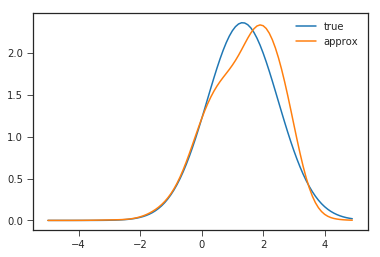

In [11]:
def true_ratio(x):
    return scipy.stats.norm(1, 1).pdf(x) / scipy.stats.norm(0, 2).pdf(x)

def approximated_ratio(x):
    return np.sum([alpha[i] * bases[i](x) for i in range(b)])

plt.plot(np.arange(-5, 5, 0.1), [true_ratio(x) for x in np.arange(-5, 5, 0.1)], label='true')
plt.plot(np.arange(-5, 5, 0.1), [approximated_ratio(x) for x in np.arange(-5, 5, 0.1)], label='approx')
plt.legend()